# Estimação da Intensidade de Ciclones Tropicais

## Introdução

Ciclones tropicais são sistemas de tempestades intensos que se originam nos oceanos em regiões próximas ao equador. Eles são caracterizados por ventos fortes, chuvas intensas e uma área de baixa pressão no centro, muitas vezes referida como o "olho" do ciclone. Os ciclones tropicais podem causar devastação em áreas costeiras, levando a inundações, danos a construções e perda de vidas. A monitorização e previsão desses fenômenos são vitais para a preparação e resposta adequadas a essas tempestades poderosas.

Dessa forma, uma vez que os furacões (ou ciclones tropicais) possuem ameaças substanciais e causam danos significativos a vidas e propriedades, estudar as etapas de um furacão é essencial para determinar seu impacto.

Porém, a análise de ciclones tropicais por meio somente de imagens de satélite não é suficiente, visto que a categoria desses é fortemente baseada na velocidade máxima dos ventos.

Sendo assim, para o problema de classificação de ciclones é utilizado a técnica Dvorak, que consiste em um algoritmo manual executado por um especialista na área que visa estimar a intensidade do ciclone com base em imagens de satélite.

![dvorak](https://www.ststworld.com/wp-content/uploads/2019/09/Dvorak_technique.jpg)

Infelizmente, por se tratar de um algoritmo manual, este é muito suscetível a erros. Dessa forma, se faz necessário a construção de um modelo que elimine erros humanos na classificação de ciclones tropicais.

As Redes Neurais Convolucionais (CNNs) são excelentes para a classificação de imagens. Elas utilizam camadas especiais que podem identificar padrões nas imagens, como bordas e formas, tornando-as altamente eficazes em distinguir diferentes categorias visuais. Essa habilidade faz das CNNs uma ferramenta popular e poderosa na análise de imagem.

Portanto, a abordagem de Redes Neurais Convolucionais - pela sua natureza - é ideal para a construção de um modelo de aprendizagem de máquina que seja eficaz no problema de classificações de ciclones tropicais.

## Objetivos

Dessa forma, o presente trabalho tem como a classificação Multi-Classe de ciclones tropicais, utilizando imagens de satélite junto com dados de intensidade:

* NC ( No Category)
* TD ( Tropical Depression )
* TS ( Topical Storm )
* H1 ( Category One )
* H2 ( Category Two )
* H3 ( Category Three )
* H4 ( Category Four )
* H5 ( Category Five )

## Materiais e métodos

O presente trabalho foi iniciado no Bootcamp _HPC para IA_, realizado no _Laboratório Nacional de Computação Científica (LNCC)_ em parceria com a _NVIDIA_. Nesse bootcamp, foi feito uma releitura do modelo descrito no Artigo de Pesquisa intitulado "Estimação da Intensidade do Ciclone Tropical Usando uma Rede Neural Convolucional Profunda" * por Ritesh Pradhan, Ramazan S. Aygun, Membro Sênior, IEEE, Manil Maskey, Membro, IEEE, Rahul Ramachandran, Membro Sênior, IEEE, e Daniel J. Cecil *

O modelo original, utiliza o _Caffe Framework_ e possui a seguinte arquitetura:

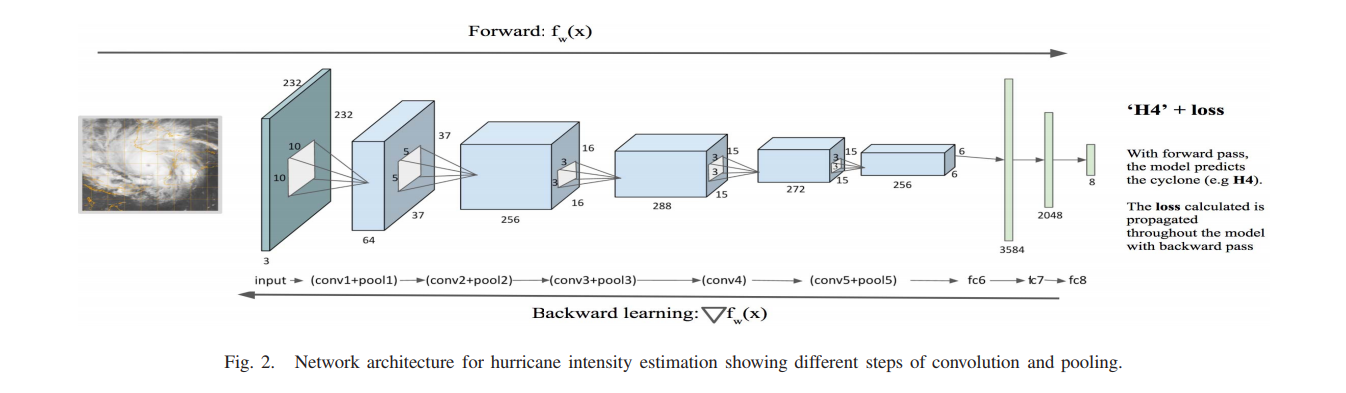

Assim, um modelo do tipo CNN utilizando o framework Keras foi desenvolvido baseando-se na arquitetura mostrada no artigo. O modelo utiliza imagens de ciclones tropicais anotadas com suas respectivas intensidades como entrada e tem como objetivo prever a intensidade de futuras imagens de satélite de ciclones tropicais.

## Configuração Do Ambiente

Bibliotecas utilizadas:

In [1]:
!pip install gdown

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import gdown
import cv2
import os
from datetime import datetime
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import random
from collections import Counter
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten ,Dropout, MaxPooling2D
from keras import backend as K
import functools
from functools import reduce

Checagem de GPUs disponíveis

In [3]:
print(tf.__version__)
tf.test.gpu_device_name()

2.12.0


'/device:GPU:0'

## Dataset

O dataset é constituído de dois componentes:

* Imagens de satélite de ciclones tropicais, fornecidas pela [marinha americana](https://www.nrlmry.navy.mil/tcdat/).

![cicl](https://www.nrlmry.navy.mil/tcdat/tc00/ATL/12L.HELENE/ir/geo/1km/20000922.1010.goes-8.ir.x.HELENE.12L.jpg)

* Dados CSV provenientes da base [hurdat2](https://www.nhc.noaa.gov/data/#hurdat), contendo diversos dados sobre ciclones tropicais (dentre eles a classe do método Dvorak).

```text
,index,id,name,date,record_identifier,status_of_system,latitude,longitude,maximum_sustained_wind_knots,maximum_pressure,34_kt_ne,34_kt_se,34_kt_sw,34_kt_nw,50_kt_ne,50_kt_se,50_kt_sw,50_kt_nw,64_kt_ne,64_kt_se,64_kt_sw,64_kt_nw
0,0,AL011851,UNNAMED,1851-06-25 00:00:00,,HU,28.0N,94.8W,80,,,,,,,,,,,,,
1,1,AL011851,UNNAMED,1851-06-25 06:00:00,,HU,28.0N,95.4W,80,,,,,,,,,,,,,

...
```





In [4]:
url_images = 'https://drive.google.com/file/d/1-GaxHdsFv_gNmFqSxz1wRhc3a9uwMgsZ/view?usp=sharing'
output_images = 'dataset.zip'

url_text = 'https://drive.google.com/file/d/1qs5c-uDTcc-RBTKqHuaQBdMpeEMjpCRn/view?usp=sharing'
output_text = 'atlantic_storms.csv'



gdown.cached_download(url_images,
                      output_images,
                      quiet=False,
                      proxy=None,
                      fuzzy=True,
                      postprocess=gdown.extractall)

gdown.cached_download(url_text,
                      output_text,
                      quiet=False,
                      proxy=None,
                      fuzzy=True)



Cached Downloading: dataset.zip
Downloading...
From: https://drive.google.com/uc?id=1-GaxHdsFv_gNmFqSxz1wRhc3a9uwMgsZ
To: /root/.cache/gdown/tmp6nnx51ap/dl
100%|██████████| 1.11G/1.11G [00:15<00:00, 73.3MB/s]
Cached Downloading: atlantic_storms.csv
Downloading...
From: https://drive.google.com/uc?id=1qs5c-uDTcc-RBTKqHuaQBdMpeEMjpCRn
To: /root/.cache/gdown/tmpk6knkjn_/dl
100%|██████████| 4.53M/4.53M [00:00<00:00, 190MB/s]


'atlantic_storms.csv'

In [5]:
dir = 'Dataset/'
a = os.listdir(dir)
a = filter(lambda x: x != 'Aug', a)

total = [
    file
    for i in a
    for j in os.listdir(dir + i)
    for k in os.listdir(dir + i + '/' + j)
    for l in os.listdir(dir + i + '/' + j + '/' + k)
    for file in os.listdir(dir + i + '/' + j + '/' + k + '/' + l + '/ir/geo/1km')
]

for i in a:
    for j in os.listdir(dir + i):
        for k in os.listdir(dir + i + '/' + j):
            for l in os.listdir(dir + i + '/' + j + '/' + k):
                e = os.listdir(dir + i + '/' + j + '/' + k + '/' + l + '/ir/geo/1km')
                print(j + '-> ' + l + ' --> ' + str(len(e)))

print('Total number of images present in the Dataset :', len(total))


Total number of images present in the Dataset : 32611


In [6]:
print('Total number of rows present in the Text Dataset:', len(pd.read_csv('atlantic_storms.csv')))

Total number of rows present in the Text Dataset: 51310


Dessa forma, o dataset de imagens será anotado com as intensidades dos ciclones obtidas do dataset de texto, a fim de alimentar o modelo de machine learning.

## Pré Processamento e conjuntos de dados

### Pré Processamento

A base de dados de imagens contem imagens de ciclones amostrada a cada 2 horas. Já a base de dados de texto, possui dados desses ciclones amostrados a cada 6 horas. Dessa forma, a função _load_dataset_ carrega as imagens, combina com os dados da base de texto e interpola os dados que faltam. Além disso, a função recebe outra função para realizar o _data augmentation_, etapa que será feita posteriormente.

In [7]:
def dummy():
  pass

def load_dataset(augment_fn=dummy):
    filenames = []
    labels = []
    i = 0
    df = pd.read_csv('atlantic_storms.csv')
    dir = 'Dataset/tcdat/'
    a = os.listdir(dir)
    file_path = "Dataset/Aug/"
    directory = os.path.dirname(file_path)

    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    aug = 0
    for j in a:
        c = os.listdir(dir + '/' + j)
        for k in c:
            d = os.listdir(dir + '/' + j + '/' + k)
            for l in d:
                print('.', end='')
                start_year = '20' + j[2:] + '-01-01'
                end_year = '20' + j[2:] + '-12-31'
                cyc_name = l[4:]
                mask = (df['date'] > start_year) & (df['date'] <= end_year) & (
                    df['name'] == cyc_name)
                cyc_pd = df.loc[mask]
                first = (datetime.strptime(cyc_pd['date'].iloc[0],
                                           "%Y-%m-%d %H:%M:%S"))
                last = (datetime.strptime(cyc_pd['date'].iloc[-1],
                                          "%Y-%m-%d %H:%M:%S"))
                text_time = []
                text_vel = []
                for q in range(len(cyc_pd['date'])):
                    text_vel.append(
                        cyc_pd['maximum_sustained_wind_knots'].iloc[q])
                    text_time.append((datetime.strptime(
                        cyc_pd['date'].iloc[q], "%Y-%m-%d %H:%M:%S") -
                                      first).total_seconds())
                func = interpolate.splrep(text_time, text_vel)
                e = os.listdir(dir + '/' + j + '/' + k + '/' + l +
                               '/ir/geo/1km')
                e.sort()
                for m in e:
                    try:
                        time = (datetime.strptime(m[:13], "%Y%m%d.%H%M"))
                        name = dir + j + '/' + k + '/' + l + '/ir/geo/1km/' + m
                        if (time > first and time < last):
                            val = int(
                                interpolate.splev(
                                    (time - first).total_seconds(), func))
                            filenames.append(name)
                            if val <= 20:
                                labels.append(0)
                            elif val > 20 and val <= 33:
                                labels.append(1)
                            elif val > 33 and val <= 63:
                                labels.append(2)
                            elif val > 63 and val <= 82:
                                labels.append(3)
                            elif val > 82 and val <= 95:
                                labels.append(4)
                            elif val > 95 and val <= 112:
                                labels.append(5)
                            elif val > 112 and val <= 136:
                                labels.append(6)
                            elif val > 136:
                                labels.append(7)
                            i = augment_fn(name, labels[-1], filenames, labels,
                                           i)
                    except:
                        pass
    print('')
    print(len(filenames))
    # Shuffle The Data
    # Zip Images with Appropriate Labels before Shuffling
    c = list(zip(filenames, labels))
    random.shuffle(c)
    #Unzip the Data Post Shuffling
    filenames, labels = zip(*c)
    filenames = list(filenames)
    labels = list(labels)
    return filenames, labels

def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [232, 232])
    return image, label


def make_dataset(train_in, test_in, val_in):
    train = tf.data.Dataset.from_tensor_slices((train_in[0], train_in[1]))
    train = train.shuffle(len(train_in[0]))
    train = train.map(parse_function, num_parallel_calls=8)
    train = train.batch(train_in[2])
    train = train.prefetch(1)
    test = tf.data.Dataset.from_tensor_slices((test_in[0], test_in[1]))
    test = test.shuffle(len(test_in[0]))
    test = test.map(parse_function, num_parallel_calls=8)
    test = test.batch(test_in[2])
    test = test.prefetch(1)
    val = tf.data.Dataset.from_tensor_slices((val_in[0], val_in[1]))
    val = val.map(parse_function, num_parallel_calls=8)
    val = val.batch(val_in[2])
    val = val.prefetch(1)
    return train, test, val


In [8]:
# Load dataset
filenames,labels = load_dataset()

................................
27582


## Conjuntos de dados

O dataset é dividido em:

* Treinamento: 70%
* Teste: 20%
* Validação: 10%

In [9]:
def make_test_set(filenames, labels, val=0.1):
    classes = 8
    j = 0
    val_filenames = []
    val_labels = []
    new = [int(val * len(filenames) / classes)] * classes
    print(new)
    try:
        for i in range(len(filenames)):
            if (new[labels[i]] > 0):
                val_filenames.append(filenames[i])
                val_labels.append(labels[i])
                new[labels[i]] = new[labels[i]] - 1
                del filenames[i]
                del labels[i]
    except:
        pass

    c = list(zip(val_filenames, val_labels))
    random.shuffle(c)
    val_filenames, val_labels = zip(*c)
    val_filenames = list(val_filenames)
    val_labels = list(val_labels)
    print(Counter(labels))
    return val_filenames, val_labels

Divisão de dados de treino em cada classe:

In [10]:
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)

[344, 344, 344, 344, 344, 344, 344, 344]
Counter({2: 7936, 3: 5339, 1: 3803, 4: 2934, 5: 2336, 6: 2178, 7: 204, 0: 100})


In [11]:
test = 0.2
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

O método de _Encoding_ utilizado é o _One Hot Encoding_:

```text
2 --- > [ 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0]

4 --- > [ 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0]
```

In [12]:
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

In [13]:
train,test,val = make_dataset((x_train,y_train,128),(x_test,y_test,32),(val_filenames,val_labels,32))

## Modelo v1: Arquitetura original

Os parâmetros das camadas, como as funções de ativação e o número de neurônios foram retirados do artigo original.

- `Conv2D(64, kernel_size=10, strides=3, activation='relu', input_shape=(232,232,3))`: Camada convolucional com 64 filtros, kernel de tamanho 10, stride de 3, ativação ReLU, e forma de entrada 232x232x3.
- `MaxPooling2D(pool_size=(3, 3), strides=2)`: Camada de pooling com tamanho de pool 3x3 e stride de 2.
- `Conv2D(256, kernel_size=5, strides=1, activation='relu')`: Camada convolucional com 256 filtros, kernel de tamanho 5, stride de 1, e ativação ReLU.
- `MaxPooling2D(pool_size=(3, 3), strides=2)`: Camada de pooling com tamanho de pool 3x3 e stride de 2.
- `Conv2D(288, kernel_size=3, strides=1, padding='same', activation='relu')`: Camada convolucional com 288 filtros, kernel de tamanho 3, stride de 1, padding do mesmo tamanho, e ativação ReLU.
- `MaxPooling2D(pool_size=(2, 2), strides=1)`: Camada de pooling com tamanho de pool 2x2 e stride de 1.
- `Conv2D(272, kernel_size=3, strides=1, padding='same', activation='relu')`: Camada convolucional com 272 filtros, kernel de tamanho 3, stride de 1, padding do mesmo tamanho, e ativação ReLU.
- `Conv2D(256, kernel_size=3, strides=1, activation='relu')`: Camada convolucional com 256 filtros, kernel de tamanho 3, stride de 1, e ativação ReLU.
- `MaxPooling2D(pool_size=(3, 3), strides=2)`: Camada de pooling com tamanho de pool 3x3 e stride de 2.
- `Dropout(0.5)`: Camada de dropout com taxa de 0.5 para regularização.
- `Flatten()`: Camada para achatamento dos dados.
- `Dense(3584, activation='relu')`: Camada densa com 3584 neurônios e ativação ReLU.
- `Dense(2048, activation='relu')`: Camada densa com 2048 neurônios e ativação ReLU.
- `Dense(8, activation='softmax')`: Camada de saída densa com 8 neurônios e ativação softmax para classificação.


In [14]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.random.set_seed(1337)

#Reset Graphs and Create Sequential model
K.clear_session()
model = Sequential()

#Convolution Layers
model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers
model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 256)       409856    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 288)       663840    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 288)      0

Os pesos iniciais do modelo foram computados e salvos. Isso vai deixar futuras execuções mais rápidas:

In [15]:
url_weights = 'https://drive.google.com/file/d/1Csj_YFAXHtnGpOutxZ9A6CBrGAsZkpXu/view?usp=sharing'
output_weights = 'model.h5'

gdown.cached_download(url_weights,
                      output_weights,
                      quiet=False,
                      proxy=None,
                      fuzzy=True)

Cached Downloading: model.h5
Downloading...
From: https://drive.google.com/uc?id=1Csj_YFAXHtnGpOutxZ9A6CBrGAsZkpXu
To: /root/.cache/gdown/tmpdcq61y5a/dl
100%|██████████| 343M/343M [00:04<00:00, 84.5MB/s]


'model.h5'

In [16]:
top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

epochs = 4
model.load_weights("model.h5")

# Optimizer
sgd = keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9)

#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy',top2_acc])

# Train the Model
trained_model = model.fit(train,
          epochs=epochs,
          verbose=1,
          validation_data=val)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/4
156/156 [==============================] - 44s 190ms/step - loss: 0.5977 - accuracy: 0.7837 - top2_acc: 0.9222 - val_loss: 0.8281 - val_accuracy: 0.7137 - val_top2_acc: 0.8964
Epoch 2/4
156/156 [==============================] - 31s 196ms/step - loss: 0.5338 - accuracy: 0.8098 - top2_acc: 0.9350 - val_loss: 0.6414 - val_accuracy: 0.7900 - val_top2_acc: 0.9150
Epoch 3/4
156/156 [==============================] - 31s 200ms/step - loss: 0.4898 - accuracy: 0.8230 - top2_acc: 0.9451 - val_loss: 0.5616 - val_accuracy: 0.8085 - val_top2_acc: 0.9382
Epoch 4/4
156/156 [==============================] - 29s 182ms/step - loss: 0.4529 - accuracy: 0.8370 - top2_acc: 0.9509 - val_loss: 0.5465 - val_accuracy: 0.8107 - val_top2_acc: 0.9353
Test loss: 0.3319806158542633
Test accuracy: 0.8848167657852173


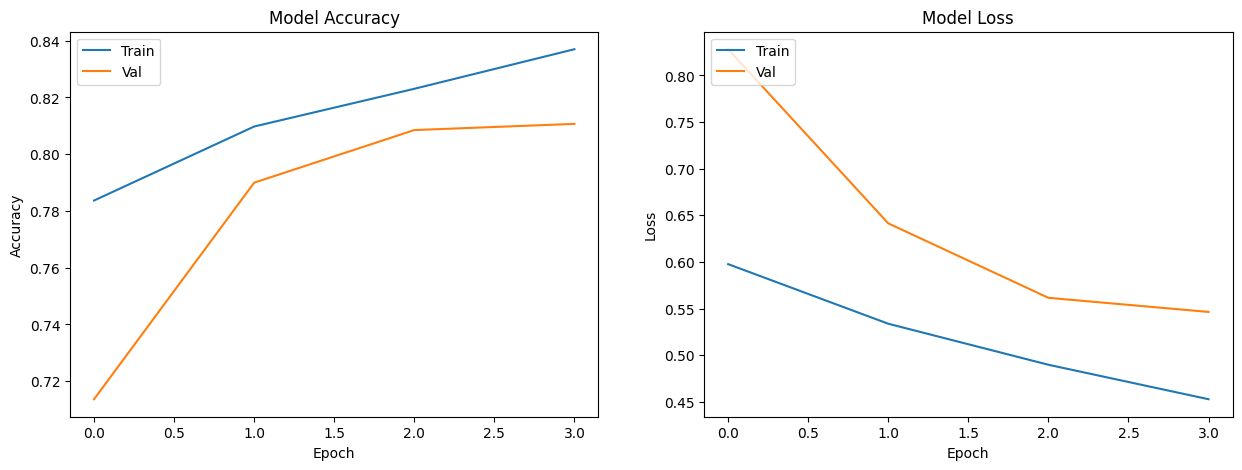

In [17]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

86/86 [==============================] - 3s 35ms/step


<Axes: >

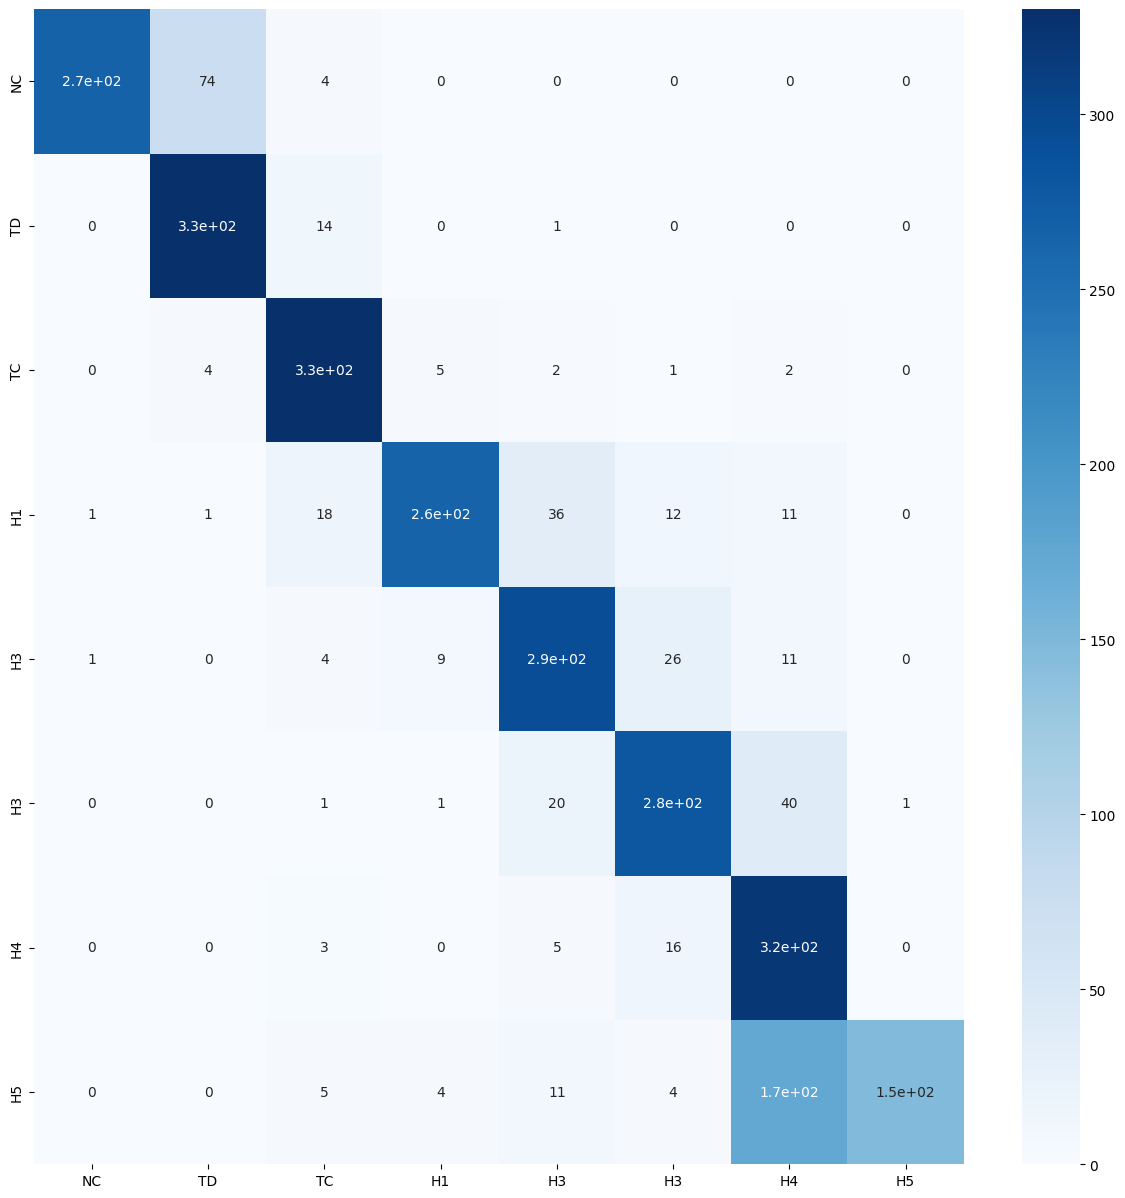

In [18]:
#Plotting a heatmap using the confusion matrix
pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p)
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

## Modelo V2: Data Augmentation

Podemos observar que a precisão da validação é menor que a precisão do treinamento. Isso ocorre porque o modelo não está devidamente regularizado e as possíveis razões são: Poucos pontos de dados e Classes desequilibradas

A primeira coisa que é possível notar na contagem de categorias é que o número de imagens por categoria é muito desigual, com proporções de TC: H5 superiores a 1:20. Esse desequilíbrio pode enviesar a visão de nosso modelo CNN, pois prever errado na classe minoritária não afetaria muito o modelo, já que a contribuição da classe é inferior a 5% do conjunto de dados.

### Data Augmentation

Assim, a técnica de data augmentation se torna necessária pra esse modelo. Basicamente, imagens com classes desiguais serão rotacionadas e invertidas para balancear a base de dados.

In [19]:
def load_image(name, interpolation=cv2.INTER_AREA):
    img = cv2.imread(name, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    inter_area = cv2.resize(img, (256, 256), interpolation=interpolation)
    start_pt = np.random.randint(24, size=2)
    end_pt = start_pt + [232, 232]
    img = inter_area[start_pt[0]:end_pt[0], start_pt[1]:end_pt[1]]
    return img

def augmentation(name, category, filenames, labels, i):
    file_path = "Dataset/Aug/"
    (h, w) = (232, 232)
    center = (w / 2, h / 2)
    img = load_image(name, interpolation=cv2.INTER_LINEAR)
    augmentations = {0: lambda x: cv2.flip(x, 0), 7: lambda x: cv2.flip(x, 0)}
    images = [aug(img) for cat, aug in augmentations.items() if cat == category]

    for j, image in enumerate(images):
        filename = file_path + str(i + j) + '.jpeg'
        cv2.imwrite(filename, image)
        filenames.append(filename)
        labels.append(category)

    return i + len(images)

Vamos usar esse função ao carregar o dataset:

In [20]:
filenames,labels = load_dataset(augment_fn = augmentation)
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)
test = 0.1
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)
train,test,val = make_dataset((x_train,y_train,128),(x_test,y_test,32),(val_filenames,val_labels,32))

................................
28574
[357, 357, 357, 357, 357, 357, 357, 357]
Counter({2: 7923, 3: 5326, 1: 3790, 4: 2921, 5: 2323, 6: 2165, 7: 739, 0: 531})


Treinando o modelo novamente:

In [21]:
#Reset Graphs and Create Sequential model
K.clear_session()
model = Sequential()

#Convolution Layers
model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers
model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 256)       409856    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 288)       663840    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 288)      0

In [22]:
# Include Top-2 Accuracy Metrics
top2_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

epochs = 4

model.load_weights("model.h5")

# Optimizer
sgd = keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9)

#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy',top2_acc])

# Train the Model
trained_model = model.fit(train,
          epochs=epochs,
          verbose=1,
          validation_data=val)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/4
181/181 [==============================] - 39s 212ms/step - loss: 0.6528 - accuracy: 0.7674 - top2_acc: 0.9124 - val_loss: 0.4762 - val_accuracy: 0.8487 - val_top2_acc: 0.9534
Epoch 2/4
181/181 [==============================] - 34s 185ms/step - loss: 0.5490 - accuracy: 0.8044 - top2_acc: 0.9320 - val_loss: 0.5124 - val_accuracy: 0.8242 - val_top2_acc: 0.9377
Epoch 3/4
181/181 [==============================] - 35s 191ms/step - loss: 0.4812 - accuracy: 0.8294 - top2_acc: 0.9445 - val_loss: 0.3726 - val_accuracy: 0.8708 - val_top2_acc: 0.9608
Epoch 4/4
181/181 [==============================] - 33s 183ms/step - loss: 0.4337 - accuracy: 0.8443 - top2_acc: 0.9542 - val_loss: 0.3152 - val_accuracy: 0.8985 - val_top2_acc: 0.9667
Test loss: 0.3379487991333008
Test accuracy: 0.8876360654830933


Visualizações:

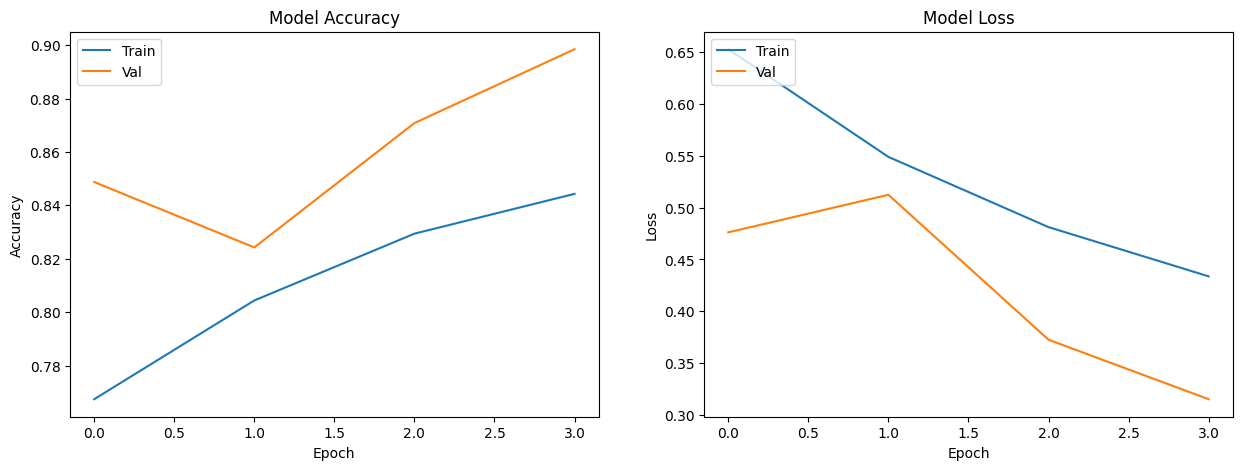

In [23]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

90/90 [==============================] - 4s 39ms/step


<Axes: >

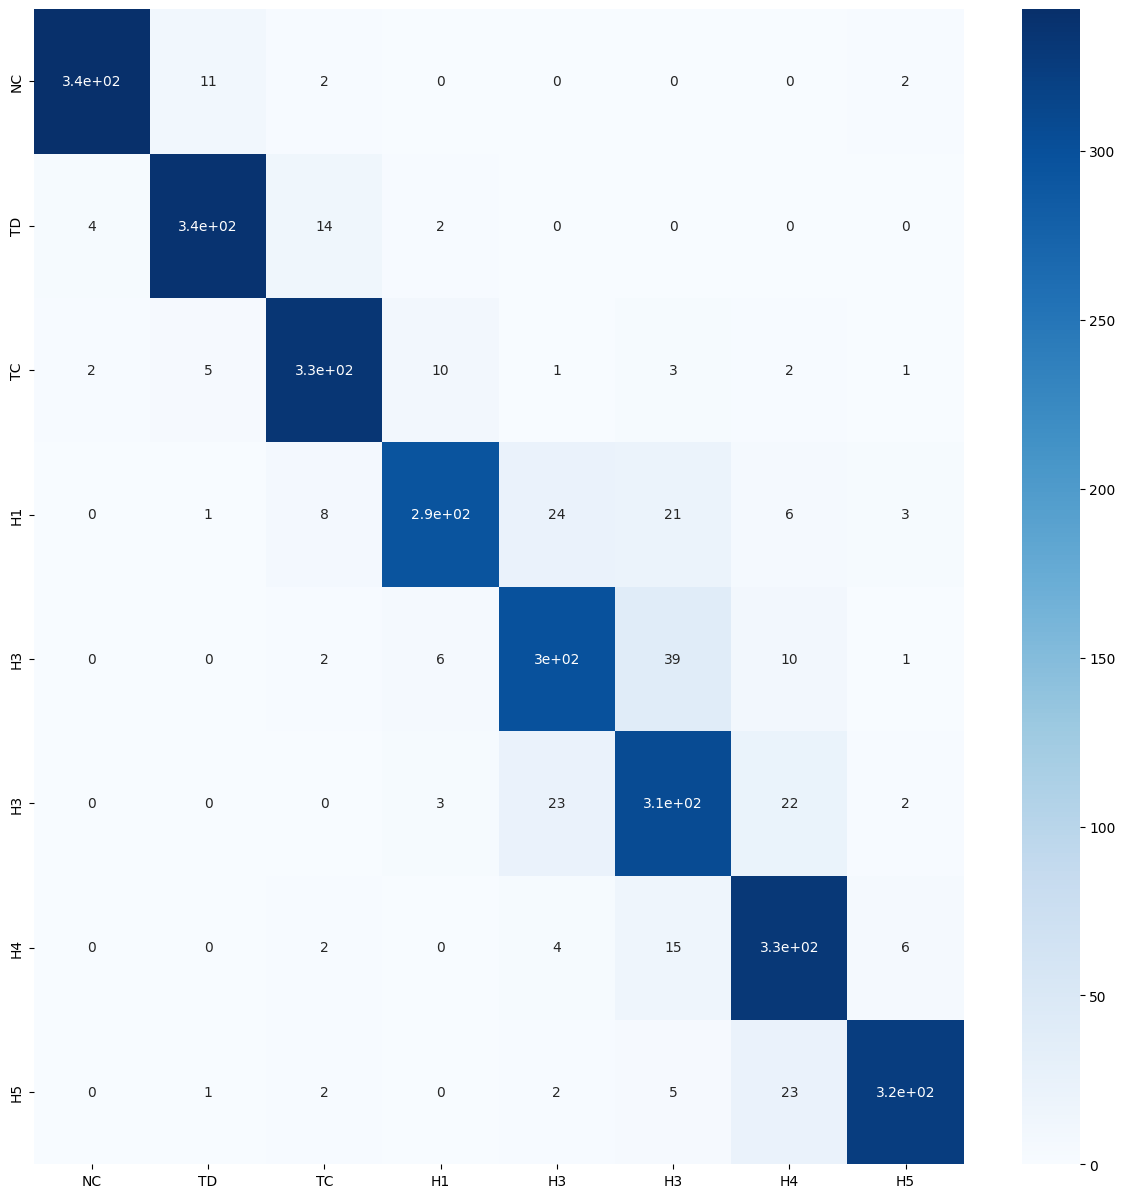

In [24]:
pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p)
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

O modelo obteve uma melhor acurácia na validação em relação ao treinamento. Portanto, vamos salvar o modelo para futuras modificações.

In [25]:
model.save('model_v2.h5')

## Modelo V3: Otimização de Hiperparâmetros

In [26]:
filenames,labels = load_dataset(augment_fn = augmentation)
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)
test = 0.1
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

................................
28574
[357, 357, 357, 357, 357, 357, 357, 357]
Counter({2: 7923, 3: 5326, 1: 3790, 4: 2921, 5: 2323, 6: 2165, 7: 739, 0: 531})


In [27]:
def build_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=10, strides=3, activation='relu', input_shape=(232, 232, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(256, kernel_size=5, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(288, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    model.add(Conv2D(272, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(3584, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    return model


Assim foi realizado um grid search simples nos hiperparâmetros: **batch size**, **epoch* e **função de otimização**. O espaço de busca é reduzido devido ao tempo de treinamento do modelo:

In [28]:
def hyperparameter_tuning():
    batch_sizes = [32, 64]
    epoch_list = [12, 24]
    optimizers = [
        keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9),
        keras.optimizers.legacy.Adam(learning_rate=0.001)
    ]

    best_accuracy = 0.0
    best_hyperparameters = None
    best_model = None

    for batch_size in batch_sizes:
        for epochs in epoch_list:
            for optimizer in optimizers:
                train, test, val = make_dataset((x_train, y_train, batch_size), (x_test, y_test, 32), (val_filenames, val_labels, 32))
                K.clear_session()
                model = build_model()
                model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy', top2_acc])

                trained_model = model.fit(train, epochs=epochs, verbose=1, validation_data=val)
                score = model.evaluate(test, verbose=0)

                if score[1] > best_accuracy:
                    best_accuracy = score[1]
                    best_hyperparameters = (batch_size, epochs, optimizer)
                    best_model = model

    return best_hyperparameters, best_model

In [29]:
best_hyperparameters, best_model = hyperparameter_tuning()
print("Best hyperparameters:", best_hyperparameters)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/12
724/724 [==============================] - 45s 61ms/step - loss: 1.6973 - accuracy: 0.3421 - top2_acc: 0.5753 - val_loss: 1.8689 - val_accuracy: 0.2812 - val_top2_acc: 0.4790
Epoch 2/12
724/724 [==============================] - 43s 59ms/step - loss: 1.3738 - accuracy: 0.4451 - top2_acc: 0.6987 - val_loss: 1.3756 - val_accuracy: 0.4356 - val_top2_acc: 0.6786
Epoch 3/12
724/724 [==============================] - 41s 56ms/step - loss: 1.1726 - accuracy: 0.5321 - top2_acc: 0.7689 - val_loss: 1.0240 - val_accuracy: 0.5963 - val_top2_acc: 0.8036
Epoch 4/12
724/724 [==============================] - 39s 53ms/step - loss: 0.9866 - accuracy: 0.6153 - top2_acc: 0.8285 - val_loss: 0.8328 - val_accuracy: 0.6702 - val_top2_acc: 0.8617
Epoch 5/12
724/724 [==============================] - 41s 56ms/step - loss: 0.8024 - accuracy: 0.6919 - top2_acc: 0.8773 - val_loss: 0.5759 - val_accuracy: 0.7994 - val_top2_acc: 0.9261
Epoch 6/12
724/724 [==============================] - 37s 52ms/step - 

Portanto os melhores hiperparâmetros encontrados foram:

* Batch Size = 32
* Epochs = 24
* Função de otimização = Stocastic Gradient Descend(keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9)_)

In [31]:
best_batch_size, best_epochs, best_optimizer = best_hyperparameters
train, test, val = make_dataset((x_train, y_train, best_batch_size), (x_test, y_test, 32), (val_filenames, val_labels, 32))
best_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=best_optimizer, metrics=['accuracy', top2_acc])
best_history = best_model.fit(train, epochs=best_epochs, verbose=1, validation_data=val)

Epoch 1/24
724/724 [==============================] - 48s 65ms/step - loss: 0.0484 - accuracy: 0.9834 - top2_acc: 0.9996 - val_loss: 0.0819 - val_accuracy: 0.9758 - val_top2_acc: 0.9982
Epoch 2/24
724/724 [==============================] - 39s 54ms/step - loss: 0.0517 - accuracy: 0.9837 - top2_acc: 0.9990 - val_loss: 0.0860 - val_accuracy: 0.9734 - val_top2_acc: 0.9972
Epoch 3/24
724/724 [==============================] - 40s 55ms/step - loss: 0.0467 - accuracy: 0.9849 - top2_acc: 0.9989 - val_loss: 0.0706 - val_accuracy: 0.9793 - val_top2_acc: 0.9989
Epoch 4/24
724/724 [==============================] - 40s 55ms/step - loss: 0.0477 - accuracy: 0.9833 - top2_acc: 0.9993 - val_loss: 0.0752 - val_accuracy: 0.9800 - val_top2_acc: 0.9982
Epoch 5/24
724/724 [==============================] - 39s 53ms/step - loss: 0.0423 - accuracy: 0.9862 - top2_acc: 0.9994 - val_loss: 0.0761 - val_accuracy: 0.9776 - val_top2_acc: 0.9982
Epoch 6/24
724/724 [==============================] - 37s 51ms/step - 

Visualizações:

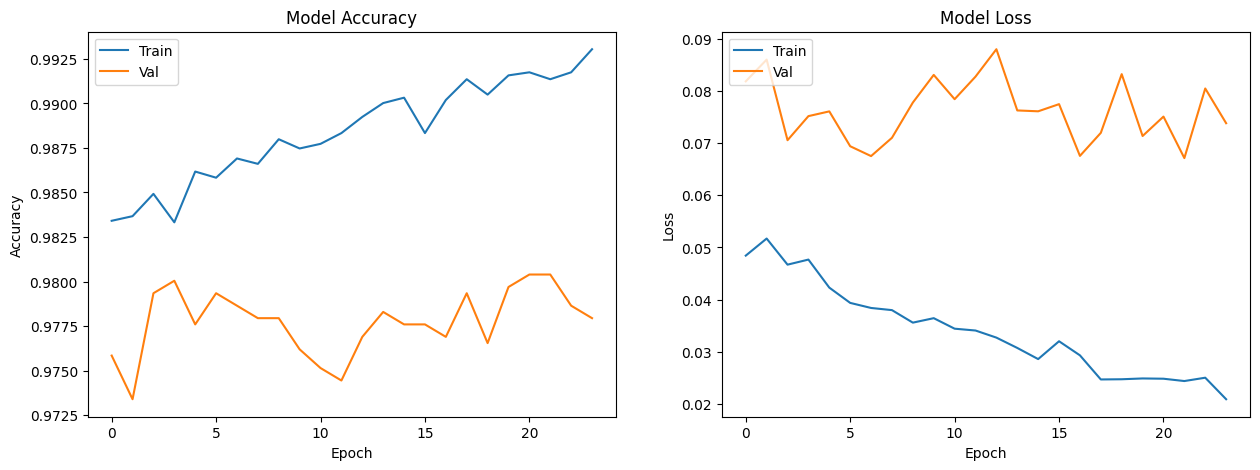

In [32]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(best_history.history['accuracy'])
ax.plot(best_history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(best_history.history['loss'])
ax2.plot(best_history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='upper left')

plt.show()

90/90 [==============================] - 3s 32ms/step


<Axes: >

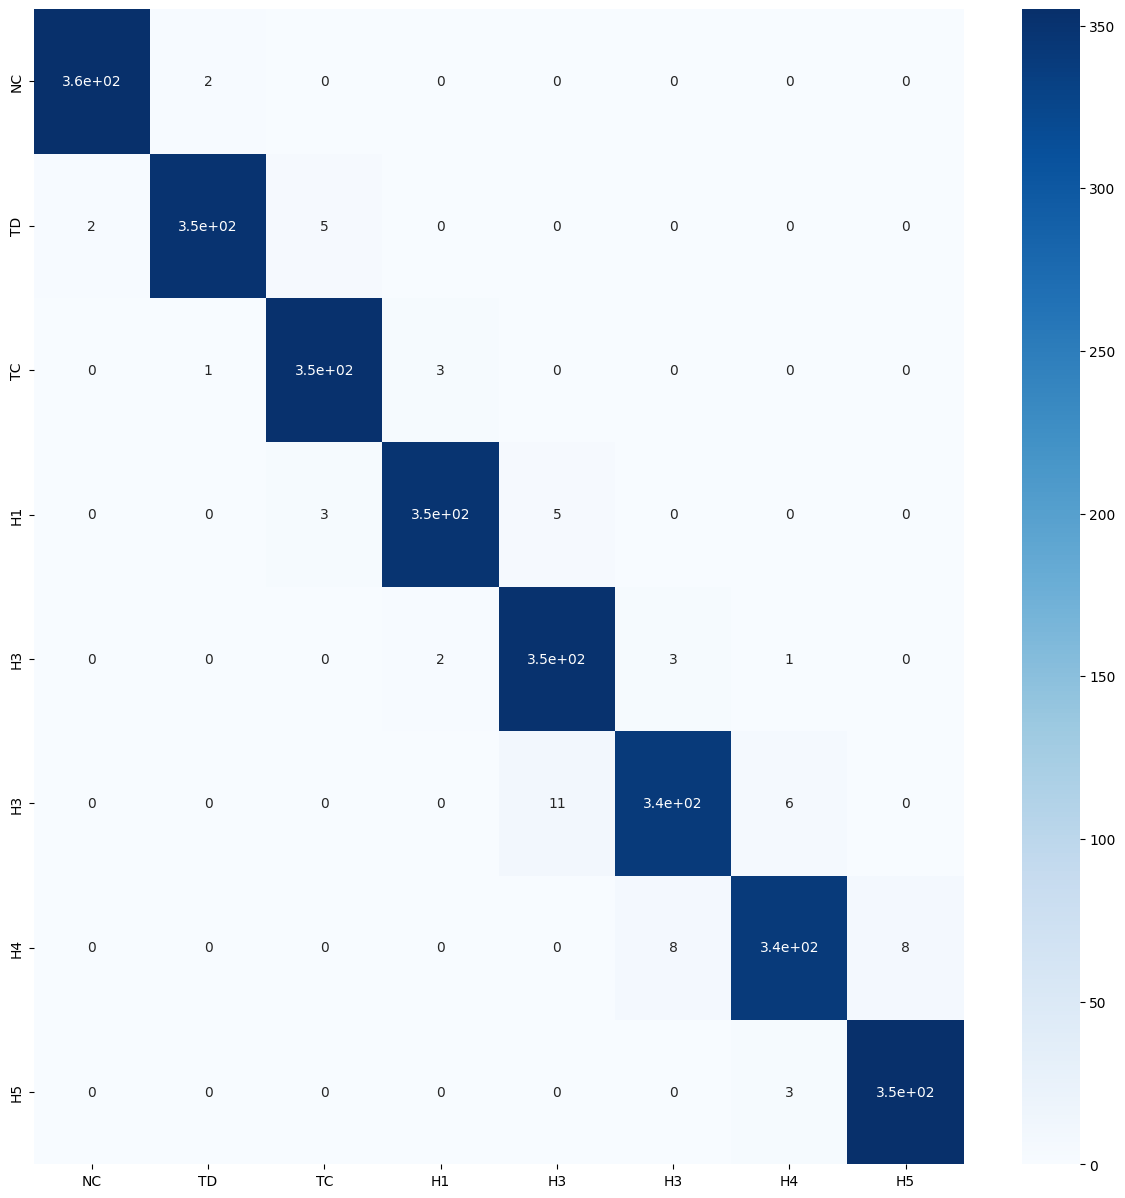

In [33]:
pred = best_model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p)
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

Salvando o modelo:

In [34]:
model.save("model_v3.h5")